## Download dataset

In [ ]:
#import kagglehub

# Download latest version
#path = kagglehub.dataset_download("kmader/mias-mammography")

#print("Path to dataset files:", path)

## Unzip dataset

In [ ]:
import zipfile
import os

def setup_dataset(zip_path, extract_dir):
    try:
        # Verifica se il file ZIP esiste
        if not os.path.exists(zip_path):
            raise FileNotFoundError(f"Il file ZIP {zip_path} non esiste!")

        # Verifica se il file è effettivamente un ZIP
        if not zipfile.is_zipfile(zip_path):
            raise ValueError(f"Il file {zip_path} non è un archivio ZIP valido!")

        # Crea la directory di estrazione se non esiste
        os.makedirs(extract_dir, exist_ok=True)

        # Estrazione con progresso
        print(f"Estrazione di {zip_path} in {extract_dir}...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)
            print(f"Estrazione completata. File estratti: {len(zip_ref.namelist())}")

        return True

    except Exception as e:
        print(f"ERRORE durante l'estrazione: {str(e)}")
        return False

# Esempio di utilizzo
success = setup_dataset(
    zip_path='balanced_imagesROI.zip',
    extract_dir='.'
)

if not success:
    print("Fallita l'estrazione del dataset!")
else:
    print("Dataset estratto con successo!")

Estrazione di balanced_imagesROI.zip in ....
Estrazione completata. File estratti: 231
Dataset estratto con successo!


### import libraries

In [ ]:
!pip install -U ultralytics albumentations ipywidgets pyyaml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 119.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import os
import shutil
import random
from pathlib import Path
import yaml
from itertools import product
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import torch
import albumentations as A
from ultralytics import YOLO
from sklearn.model_selection import KFold
from collections import Counter

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


### Overview of dataset

In [ ]:
df = pd.read_csv('objyolo.csv', sep=',')
df.head()

,REFNUM,CLASS,X,Y,RADIUS
0,mdb272,NORM,NaN,NaN,NaN
1,mdb029,NORM,NaN,NaN,NaN
2,mdb108,NORM,NaN,NaN,NaN
3,mdb149,NORM,NaN,NaN,NaN
4,mdb278,NORM,NaN,NaN,NaN


### Class distribution

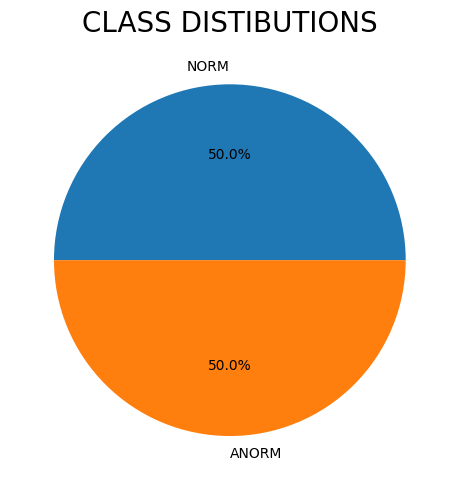

In [ ]:
#df['CLASS'] = df['CLASS'].apply(lambda x : 'MASS' if x in ['CIRC','SPIC', 'MISC', 'CALC','ARCH', 'ASYM'] else x)
# Define labels as the unique classes
labels = df['CLASS'].value_counts().index.tolist()

# Plot pie chart
plt.figure(figsize=(8, 5), edgecolor='black')
plt.pie(
    df['CLASS'].value_counts(),
    labels=labels,
    autopct='%1.1f%%',
    textprops={'fontsize': 10}
)
plt.title('CLASS DISTIBUTIONS', fontsize=20)
plt.tight_layout()
plt.show()

### Clean dataset and modify csv

In [ ]:
df = df.drop(df[(df['CLASS'] != 'NORM') & (df['X'].isnull())].index)
df = df.fillna(0)

# Calculate height and width (2 * RADIUS for both)
df['WIDTH'] = df['RADIUS'] * 2
df['HEIGHT'] = df['RADIUS'] * 2

#label encoding
df['CLASS'] = df['CLASS'].map({'NORM':0 , 'ANORM':1})

In [ ]:
df.head()

,REFNUM,CLASS,X,Y,RADIUS,WIDTH,HEIGHT
0,mdb272,0,0.0,0.0,0.0,0.0,0.0
1,mdb029,0,0.0,0.0,0.0,0.0,0.0
2,mdb108,0,0.0,0.0,0.0,0.0,0.0
3,mdb149,0,0.0,0.0,0.0,0.0,0.0
4,mdb278,0,0.0,0.0,0.0,0.0,0.0


### Draw boundary box on 1 mammography

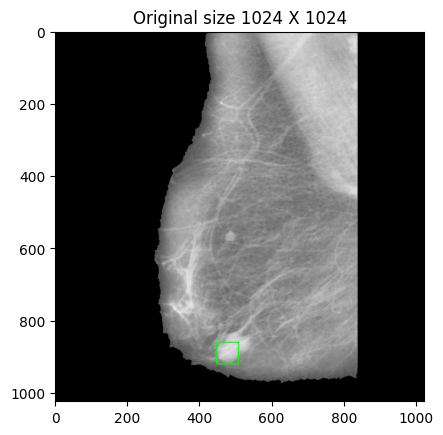

In [ ]:
width = 1024
height = 1024

# Load the image
image = cv2.imread('/content/all-mias/mdb005.jpg')

# Define the bounding box in (x_center, y_center, width, height)
x_center = 477
y_center = height - 133 # Coordinate system origin is the bottom-left corner. (convert it to be top-left)
width = 30
height = 30

# Calculate top-left and bottom-right coordinates
x_min = int(x_center - width)
y_min = int(y_center - height)
x_max = int(x_center + width)
y_max = int(y_center + height)

# Draw the bounding box on the image
color = (0, 255, 0)  # Green color in BGR
thickness = 2
cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color, thickness)

# Display the image
plt.title('Original size 1024 X 1024')
plt.imshow(image)

### Prepare data to fit yolov11 structure

In [ ]:
#Create directories

(Path("dataset") / "images").mkdir(parents=True, exist_ok=True)
(Path("dataset") / "labels").mkdir(parents=True, exist_ok=True)

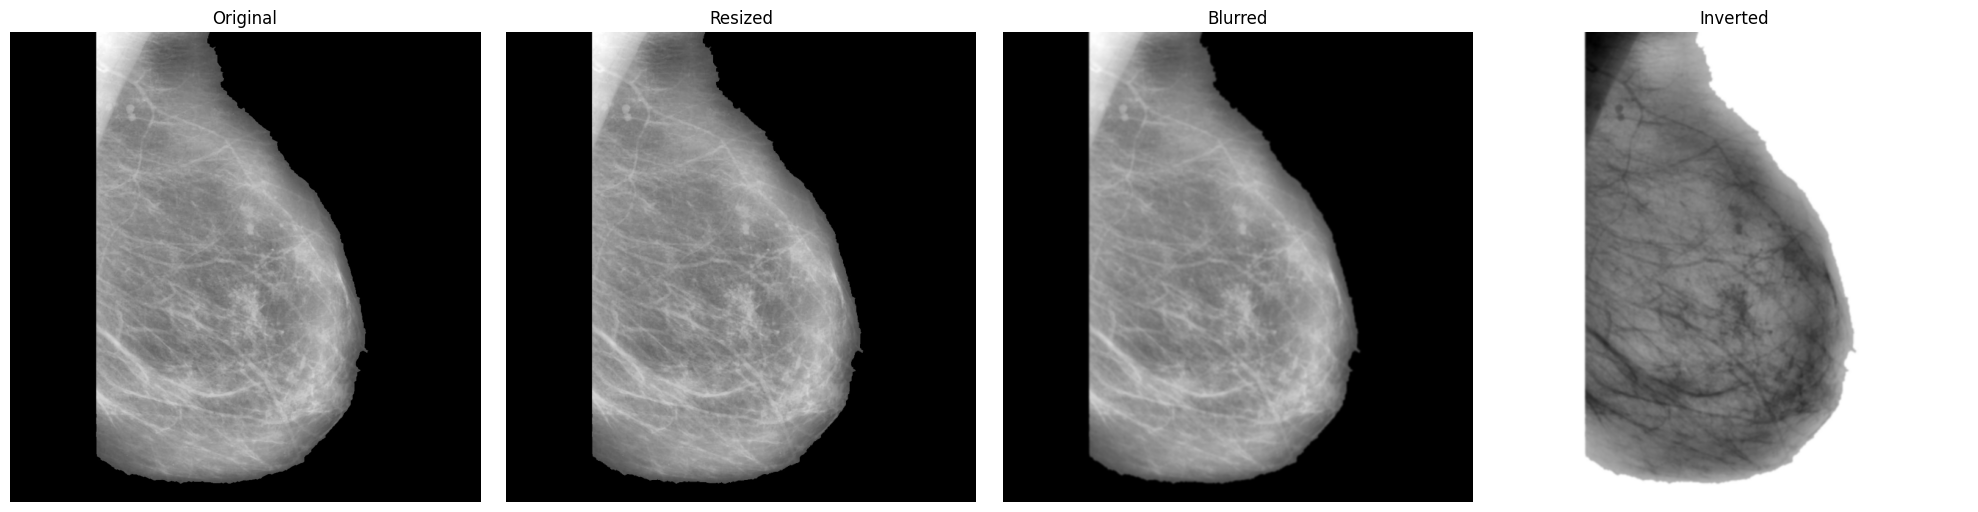

In [ ]:
# Step 1: Clean DataFrame — convert problematic columns to numeric
cols_to_fix = ['X', 'Y', 'RADIUS', 'WIDTH', 'HEIGHT']

for col in cols_to_fix:
    df[col] = pd.to_numeric(df[col], errors='coerce')  # turn invalid values into NaN

df = df.dropna(subset=['X', 'Y'])  # drop rows where X or Y is still invalid
df = df.fillna(0)  # optional: fill remaining NaNs in other fields with 0

# Ensure types are numeric
df[cols_to_fix] = df[cols_to_fix].astype(float)

# Set up constants
width = 640
height = 640
resize_factor = 0.625

# Create folders if they don't exist
os.makedirs('dataset/images', exist_ok=True)
os.makedirs('dataset/labels', exist_ok=True)

plotted = False  # only plot one example

for row in df.itertuples(index=False):
    REFNUM, CLASS, X, Y, RADIUS, WIDTH, HEIGHT = row
    image_path = f'/content/all-mias/{REFNUM}.jpg'

    image = cv2.imread(image_path)
    if image is None:
        print(f"Warning: Couldn't read image {image_path}")
        continue

    original = image.copy()
    image = cv2.resize(image, (width, height))
    resized = image.copy()

    image = cv2.GaussianBlur(image, (5, 5), 0)
    blurred = image.copy()

    image = tf.math.subtract(tf.reduce_max(image), image)
    image = image.numpy()
    inverted = image.copy()

    cv2.imwrite(f'dataset/images/{REFNUM}.png', image)

    with open(f'dataset/labels/{REFNUM}.txt', "a") as file:
        if (X != 0) and (Y != 0):
            class_label = CLASS
            X = X * resize_factor
            Y = Y * resize_factor
            Y = height - Y

            x_center_norm = X / width
            y_center_norm = Y / height
            w_norm = WIDTH / width
            h_norm = HEIGHT / height

            annotation = f"{class_label} {x_center_norm:.6f} {y_center_norm:.6f} {w_norm:.6f} {h_norm:.6f} \n"
        else:
            annotation = ''
        file.write(annotation)

    # Plot only the first image with all stages
    if not plotted:
        fig, axes = plt.subplots(1, 4, figsize=(20, 5))
        axes[0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
        axes[0].set_title('Original')

        axes[1].imshow(cv2.cvtColor(resized, cv2.COLOR_BGR2RGB))
        axes[1].set_title('Resized')

        axes[2].imshow(cv2.cvtColor(blurred, cv2.COLOR_BGR2RGB))
        axes[2].set_title('Blurred')

        axes[3].imshow(cv2.cvtColor(inverted, cv2.COLOR_BGR2RGB))
        axes[3].set_title('Inverted')

        for ax in axes:
            ax.axis('off')
        plt.tight_layout()
        plt.show()

        plotted = True


### Augmentation

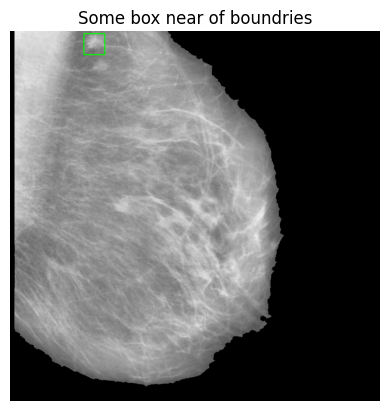

In [ ]:
width = 1024
height = 1024

# Load the image
image = cv2.imread('/content/all-mias/mdb144.jpg')

# Define the bounding box in (x_center, y_center, width, height)
x_center = 233
y_center = height - 988 # Coordinate system origin is the bottom-left corner. (convert it to be top-left)
width = 58
height = 58

# Calculate top-left and bottom-right coordinates
x_min = int(x_center - width/2)
y_min = int(y_center - height/2)
x_max = int(x_center + width/2)
y_max = int(y_center + height/2)

# Draw the bounding box on the image
color = (0, 255, 0)  # Green color in BGR
thickness = 2
cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color, thickness)

# Display the image
plt.title('Some box near of boundries')
plt.axis('off')
plt.imshow(image)

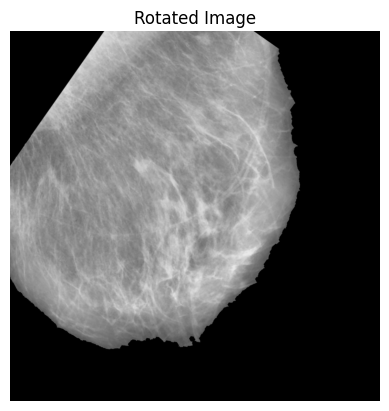

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image = cv2.imread('/content/all-mias/mdb144.jpg')  # Replace with your image path
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for proper display

# Define the rotation angle and center
angle = -35  # Angle in degrees
(h, w) = image.shape[:2]
center = (w // 2, h // 2)

# Get the rotation matrix
rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)

# Perform the rotation
rotated_image = cv2.warpAffine(image, rotation_matrix, (w, h))

# Display the rotated image
plt.imshow(rotated_image)
plt.axis('off')
plt.title('Rotated Image')
plt.show()

In [ ]:
import os
import cv2
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import random

# Augmentation pipeline (con bbox)
bbox_augmentation = A.Compose([
    A.RandomResizedCrop(size=(640, 640), scale=(0.8, 1.0), p=0.5),
    A.Rotate(limit=15, p=1.0),
    A.RandomBrightnessContrast(p=0.2),
    A.HorizontalFlip(p=0.5),
    A.Blur(blur_limit=3, p=0.1),
], bbox_params=A.BboxParams(format='yolo', min_visibility=0.5))

# Augmentation pipeline (senza bbox, per immagini background)
no_bbox_augmentation = A.Compose([
    A.RandomResizedCrop(size=(640, 640), scale=(0.8, 1.0), p=0.5),
    A.Rotate(limit=15, p=1.0),
    A.RandomBrightnessContrast(p=0.2),
    A.HorizontalFlip(p=0.5),
    A.Blur(blur_limit=3, p=0.1),
])

# Directory paths
image_dir = 'dataset/images'
label_dir = 'dataset/labels'
num_augmentations_mass = 52
num_augmentations_nomass = 50

for image_name in os.listdir(image_dir):
    if image_name.endswith('.png'):
        image_path = os.path.join(image_dir, image_name)
        image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

        label_path = os.path.join(label_dir, image_name.replace('.png', '.txt'))
        bboxes = []

        # Legge la label se esiste
        if os.path.exists(label_path):
            with open(label_path, 'r') as file:
                for line in file:
                    parts = line.strip().split()
                    if len(parts) == 5:
                        class_id, x_center, y_center, width, height = map(float, parts)
                        bboxes.append([x_center, y_center, width, height, int(class_id)])  # int() evita '1.0'

        if bboxes:
           for i in range(num_augmentations_mass):
              # Applica l'augmentation con bounding boxes
              try:
                  augmented = bbox_augmentation(image=image, bboxes=bboxes)
                  aug_image = augmented['image']
                  aug_bboxes = augmented['bboxes']
              except Exception as e:
                  print(f"Errore con bounding boxes in {image_name}: {e}")
                  continue

              # Salva immagine aumentata
              aug_image_name = f"{image_name.replace('.png', '')}_aug_{i + 1}.png"
              aug_image_path = os.path.join(image_dir, aug_image_name)
              cv2.imwrite(aug_image_path, aug_image)

              # Salva file label aumentata
              aug_label_path = os.path.join(label_dir, aug_image_name.replace('.png', '.txt'))
              with open(aug_label_path, 'w') as out_label_file:
                 for bbox in aug_bboxes:
                    x, y, w, h, class_id = bbox
                    out_label_file.write(f"{int(class_id)} {x:.6f} {y:.6f} {w:.6f} {h:.6f}\n")
        else:
           for i in range(num_augmentations_nomass):
              # Nessuna bbox: usa augmentazione base
              aug_image = no_bbox_augmentation(image=image)['image']
              aug_bboxes = []

              # Salva immagine aumentata
              aug_image_name = f"{image_name.replace('.png', '')}_aug_{i + 1}.png"
              aug_image_path = os.path.join(image_dir, aug_image_name)
              cv2.imwrite(aug_image_path, aug_image)

              # Salva file label aumentata
              aug_label_path = os.path.join(label_dir, aug_image_name.replace('.png', '.txt'))
              with open(aug_label_path, 'w') as out_label_file:
                 for bbox in aug_bboxes:
                    x, y, w, h, class_id = bbox
                    out_label_file.write(f"{int(class_id)} {x:.6f} {y:.6f} {w:.6f} {h:.6f}\n")

print("✔️ Completato: immagini aumentate e salvate correttamente.")


Errore con bounding boxes in mdb270.png: Expected y_min for bbox [    0.23516   -0.035352     0.46016     0.18965           1] to be in the range [0.0, 1.0], got -0.03535199910402298.
Errore con bounding boxes in mdb270.png: Expected y_min for bbox [    0.23516   -0.035352     0.46016     0.18965           1] to be in the range [0.0, 1.0], got -0.03535199910402298.
Errore con bounding boxes in mdb270.png: Expected y_min for bbox [    0.23516   -0.035352     0.46016     0.18965           1] to be in the range [0.0, 1.0], got -0.03535199910402298.
Errore con bounding boxes in mdb270.png: Expected y_min for bbox [    0.23516   -0.035352     0.46016     0.18965           1] to be in the range [0.0, 1.0], got -0.03535199910402298.
Errore con bounding boxes in mdb270.png: Expected y_min for bbox [    0.23516   -0.035352     0.46016     0.18965           1] to be in the range [0.0, 1.0], got -0.03535199910402298.
Errore con bounding boxes in mdb270.png: Expected y_min for bbox [    0.23516   

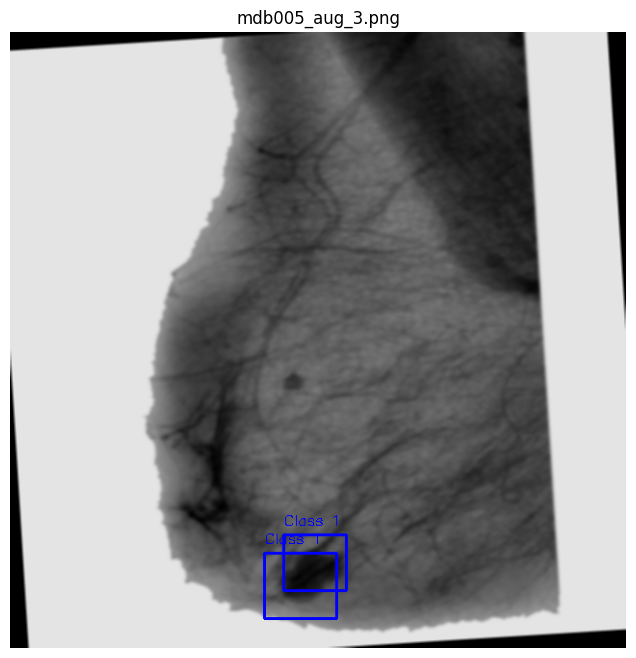

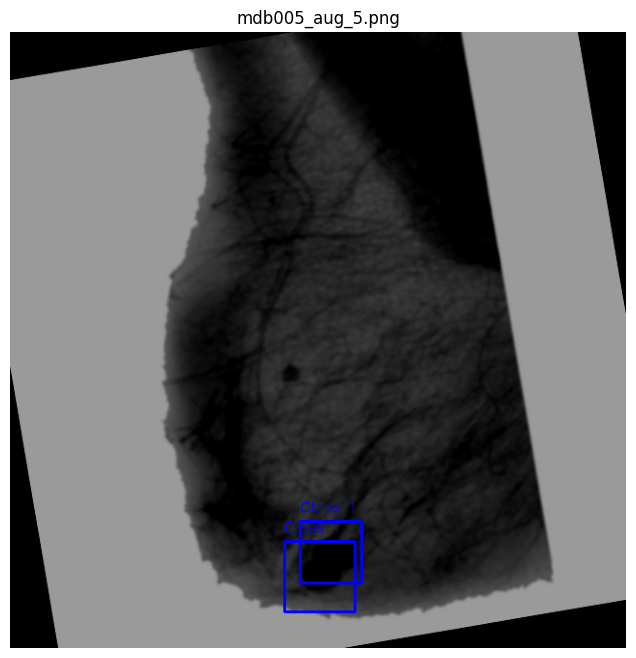

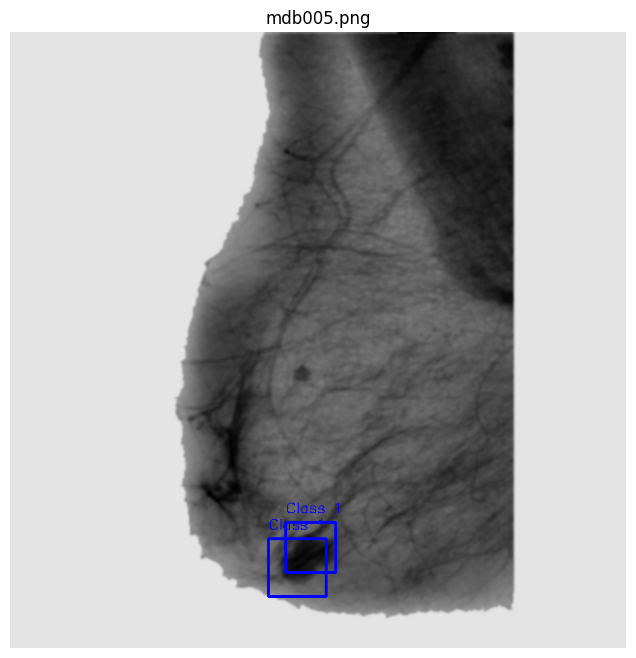

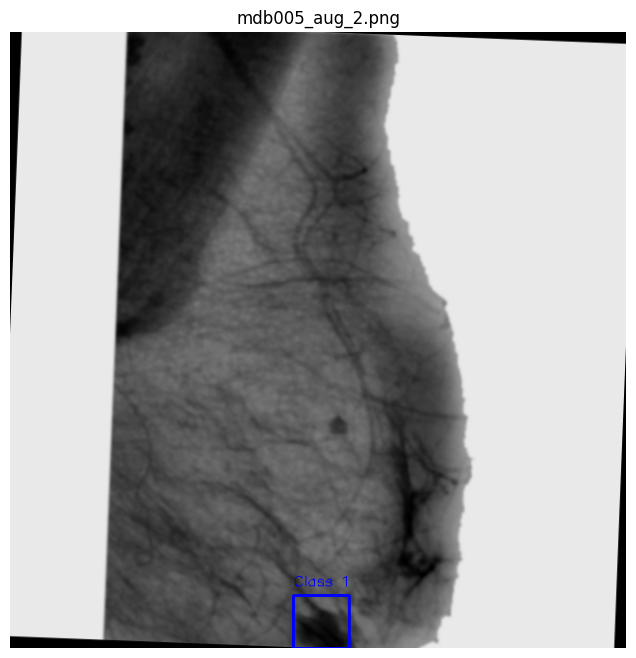

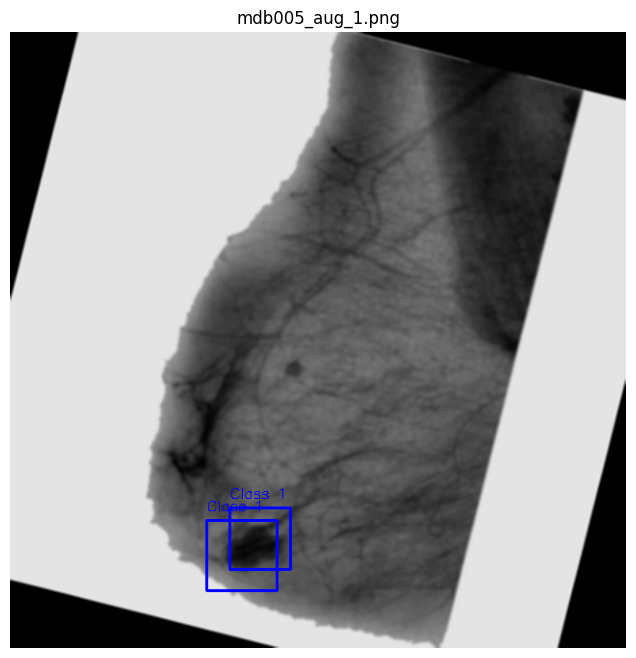

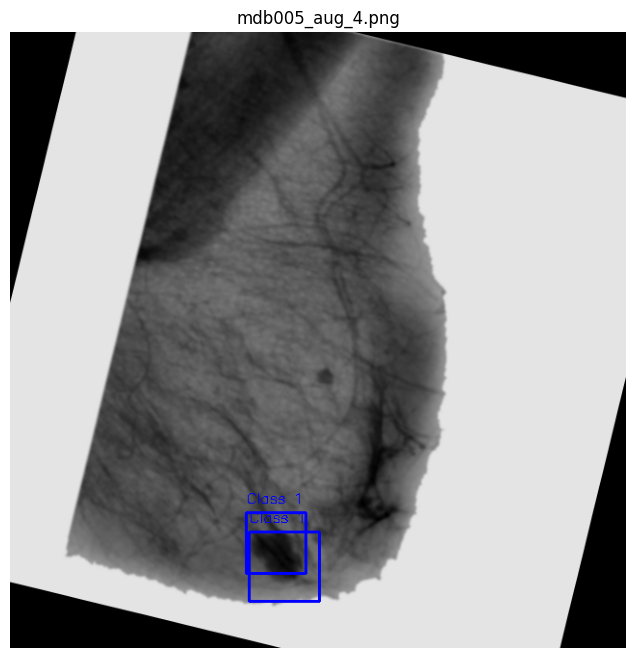

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

# Directory contenente immagini e label YOLO
image_dir = 'dataset2/images'
label_dir = 'dataset2/labels'

# Cerca immagini che iniziano con 'mdb005'
for image_name in os.listdir(image_dir):
    if image_name.startswith("mdb005") and image_name.endswith(".png"):
        image_path = os.path.join(image_dir, image_name)
        label_path = os.path.join(label_dir, image_name.replace(".png", ".txt"))

        # Carica immagine
        image = cv2.imread(image_path)
        if image is None:
            print(f"⚠️ Immagine non trovata o corrotta: {image_name}")
            continue

        img_height, img_width = image.shape[:2]  # ⬅️ dimensione dinamica

        # Leggi file label YOLO (classe, x_center, y_center, w, h) normalizzati
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) != 5:
                        continue  # skip righe malformate
                    class_id, x_center, y_center, w, h = map(float, parts)

                    # Converti in coordinate pixel
                    x_center *= img_width
                    y_center *= img_height
                    w *= img_width
                    h *= img_height

                    # Calcola coordinate bounding box
                    x1 = int(x_center - w / 2)
                    y1 = int(y_center - h / 2)
                    x2 = int(x_center + w / 2)
                    y2 = int(y_center + h / 2)

                    # Disegna rettangolo e classe
                    cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
                    cv2.putText(image, f'Class {int(class_id)}', (x1, max(y1 - 10, 10)),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

        # Mostra immagine con bounding box
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(8, 8))
        plt.imshow(image_rgb)
        plt.title(image_name)
        plt.axis('off')
        plt.show()


### New class distribution

In [ ]:
class_label = []
for dir, _, filenames in os.walk('dataset/labels'):
    for filename in filenames:
        with open(os.path.join(dir,filename), 'r') as file:
            file = file.readline()
            if file == '':
                class_label.append('0')
            else:
                file = file.split()
                class_label.append(file[0])

# Get value counts
counts = Counter(class_label)

# Print the result
print(counts)

Counter({'0': 6074, '1': 5722})


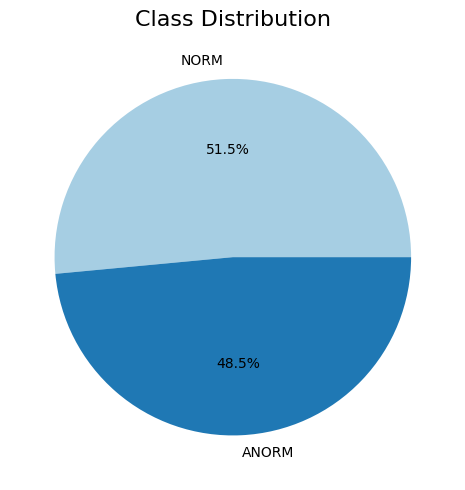

In [ ]:

# Pie Chart
plt.figure(figsize=(8, 5))
labels = counts.keys()
# Create a mapping for the labels
label_mapping = {'0': 'NORM', '1': 'ANORM'}
# Generate the labels using the mapping
labels = [label_mapping[key] for key in counts.keys()]
plt.pie(
    counts.values(),
    labels=labels,
    autopct='%1.1f%%',
    startangle=0,
    colors=plt.cm.Paired.colors,
    textprops={'fontsize': 10}
)
plt.title('Class Distribution', fontsize=16)
plt.tight_layout()
plt.show()

### Train split

In [ ]:
# Paths to the original dataset
images_dir = "dataset/images"  # Path to images directory
labels_dir = "dataset/labels"  # Path to labels directory

# Target directories for splits
output_dirs = {
    "train": {"images": "dataset_holdout/train/images", "labels": "dataset_holdout/train/labels"},
    "val": {"images": "dataset_holdout/val/images", "labels": "dataset_holdout/val/labels"},
    "test": {"images": "dataset_holdout/test/images", "labels": "dataset_holdout/test/labels"}
}

# Create target directories if they don't exist
for split, paths in output_dirs.items():
    for path in paths.values():
        os.makedirs(path, exist_ok=True)

# Define split ratios (train, val, test)
train_ratio = 0.8
test_ratio = 0.2

# Gather all image files (assumes images and labels have the same base names)
image_files = [f for f in os.listdir(images_dir) if f.endswith('.png')]
random.shuffle(image_files)

# Calculate split sizes
total_images = len(image_files)
train_count = int(total_images * train_ratio)
test_count = total_images - train_count   # Remaining images for test split

# Split dataset
splits = {
    "train": image_files[:train_count],
    "test": image_files[train_count :]
}

# Copy files to corresponding directories
for split, files in splits.items():
    for file in files:
        # Copy image
        src_image_path = os.path.join(images_dir, file)
        dest_image_path = os.path.join(output_dirs[split]["images"], file)
        shutil.copy(src_image_path, dest_image_path)

        # Copy label (assumes label file has same base name as image)
        file = Path(file)
        label_file = file.with_suffix(".txt")
        src_label_path = os.path.join(labels_dir, label_file)
        dest_label_path = os.path.join(output_dirs[split]["labels"], label_file)
        if os.path.exists(src_label_path):
            shutil.copy(src_label_path, dest_label_path)

print("Dataset split and files copied successfully!")

Dataset split and files copied successfully!


### Define yaml file

In [ ]:
# Define the data for the YAML file
data = {
    'path': '/content/dataset_holdout',
    'names': {0:'NORM', 1:'ANORM'},
    'nc': 2,
    'train': 'train',
    'val': 'val',
    'test': 'test'
}

# Save the data to a YAML file
with open('dataset_holdout/data.yaml', 'w') as file:
    yaml.dump(data, file)

print("data.yaml file created!")

data.yaml file created!


## Train model

In [ ]:
# 1. Setup and get labels
dataset_path = Path("dataset_holdout/train")  # replace with 'path/to/dataset' for your custom data
labels = sorted(dataset_path.rglob("*labels/*.txt"))  # all data in 'labels'

# 2. Read YAML and create feature vectors
yaml_file = "dataset_holdout/data.yaml"  # your data YAML with data directories and names dictionary
with open(yaml_file, "r", encoding="utf8") as y:
    classes = yaml.safe_load(y)["names"]
cls_idx = sorted(classes.keys())

# Initialize DataFrame
indx = [label.stem for label in labels]
labels_df = pd.DataFrame([], columns=cls_idx, index=indx)

# Count instances
for label in labels:
    lbl_counter = Counter()
    with open(label, "r") as lf:
        lines = lf.readlines()
    for line in lines:
        lbl_counter[int(line.split(" ")[0])] += 1
    labels_df.loc[label.stem] = lbl_counter
labels_df = labels_df.fillna(0.0)

# 3. Create k-fold splits
ksplit = 5
kf = KFold(n_splits=ksplit, shuffle=True, random_state=20)
kfolds = list(kf.split(labels_df))

# 4. Create fold directories
folds = [f"split_{n}" for n in range(1, ksplit + 1)]
folds_df = pd.DataFrame(index=indx, columns=folds)
for idx, (train, val) in enumerate(kfolds, start=1):
    folds_df[f"split_{idx}"].loc[labels_df.iloc[train].index] = "train"
    folds_df[f"split_{idx}"].loc[labels_df.iloc[val].index] = "val"

# 5. Setup directories and YAML files
supported_extensions = [".jpg", ".jpeg", ".png"]
images = []
for ext in supported_extensions:
    images.extend(sorted((dataset_path / "images").rglob(f"*{ext}")))

save_path = Path(f"/{ksplit}-Fold_Cross-val")
save_path.mkdir(parents=True, exist_ok=True)
ds_yamls = []
for split in folds_df.columns:
    # Create directories
    split_dir = save_path / split
    split_dir.mkdir(parents=True, exist_ok=True)
    (split_dir / "train" / "images").mkdir(parents=True, exist_ok=True)
    (split_dir / "train" / "labels").mkdir(parents=True, exist_ok=True)
    (split_dir / "val" / "images").mkdir(parents=True, exist_ok=True)
    (split_dir / "val" / "labels").mkdir(parents=True, exist_ok=True)

    # Create dataset YAML files
    dataset_yaml = split_dir / f"{split}_dataset.yaml"
    ds_yamls.append(dataset_yaml)
    with open(dataset_yaml, "w") as ds_y:
        yaml.safe_dump(
            {
                "path": split_dir.as_posix(),
                "train": "train",
                "val": "val",
                "names": classes,
            },
            ds_y,
        )
# 6. Copy images and labels to respective directories
for image, label in zip(images, labels):
    for split, k_split in folds_df.loc[image.stem].items():
        img_to_path = save_path / split / k_split / "images"
        lbl_to_path = save_path / split / k_split / "labels"
        shutil.copy(image, img_to_path / image.name)
        shutil.copy(label, lbl_to_path / label.name)

/tmp/ipython-input-30-3206268603.py:23: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  labels_df = labels_df.fillna(0.0)
/tmp/ipython-input-30-3206268603.py:34: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensu

In [ ]:
# Define grid search parameters
batch_sizes = [32]
epochs = [50]

# Create all combinations of hyperparameters
grid = list(product(batch_sizes, epochs))

# Path to your initial weights
weights_path = "yolov8n-p2.yaml"

# Perform grid search
for batch, ep in grid:
    print(f"batch_size={batch}, epochs={ep}")

    # Loop over each fold
    for k, dataset_yaml in enumerate(ds_yamls):
        print(f"Training on fold {k+1}")

        # Initialize YOLO model
        model = YOLO(weights_path, task="detect")

        # Train model with the current combination of hyperparameters
        model.train(
            data=dataset_yaml,
            epochs=ep,
            batch=batch,
            project="kfold_gridsearch2",
            name=f"fold{k+1}_batch{batch}_epochs{ep}",
            patience = 5
        )

batch_size=32, epochs=50
Training on fold 1
Ultralytics 8.3.167 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/5-Fold_Cross-val/split_1/split_1_dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-p2.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=fold1_batch32_epochs50, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto,

100%|██████████| 755k/755k [00:00<00:00, 37.2MB/s]

Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

YOLOv8n-p2 summary: 160 layers, 2,926,824 parameters, 2,926,808 gradients, 12.4 GFLOPs

Freezing layer 'model.28.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 120MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 872.2±1198.3 MB/s, size: 189.8 KB)


train: Scanning /5-Fold_Cross-val/split_1/train/labels... 7548 images, 3871 backgrounds, 0 corrupt: 100%|██████████| 7548/7548 [00:26<00:00, 283.56it/s] 


train: New cache created: /5-Fold_Cross-val/split_1/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 32.4±10.6 MB/s, size: 170.2 KB)


val: Scanning /5-Fold_Cross-val/split_1/val/labels... 1888 images, 942 backgrounds, 0 corrupt: 100%|██████████| 1888/1888 [00:07<00:00, 246.08it/s]

val: New cache created: /5-Fold_Cross-val/split_1/val/labels.cache


Plotting labels to kfold_gridsearch2/fold1_batch32_epochs50/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 70 weight(decay=0.0), 79 weight(decay=0.0005), 78 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to kfold_gridsearch2/fold1_batch32_epochs50
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      6.65G      2.602      6.462      3.534         31        640: 100%|██████████| 236/236 [03:03<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:26<00:00,  1.14it/s]


                   all       1888       1018    0.00476      0.101    0.00317    0.00136

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      6.38G      2.206      4.349      2.817         31        640: 100%|██████████| 236/236 [02:49<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:23<00:00,  1.28it/s]


                   all       1888       1018       0.28      0.195      0.139     0.0581

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      7.15G      2.062      3.443      2.674         20        640: 100%|██████████| 236/236 [02:44<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


                   all       1888       1018      0.231      0.112     0.0738     0.0256

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      7.17G      1.951      3.168      2.553         19        640: 100%|██████████| 236/236 [02:42<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:22<00:00,  1.35it/s]


                   all       1888       1018      0.335      0.264      0.218      0.103

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      7.19G      1.795      2.903      2.388         28        640: 100%|██████████| 236/236 [02:41<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.39it/s]


                   all       1888       1018      0.278      0.256       0.18     0.0931

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50       7.2G      1.708      2.733      2.308         22        640: 100%|██████████| 236/236 [02:41<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:22<00:00,  1.35it/s]

                   all       1888       1018       0.41       0.28      0.251      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      7.22G      1.628      2.528      2.218         27        640: 100%|██████████| 236/236 [02:39<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:22<00:00,  1.36it/s]


                   all       1888       1018      0.409      0.368      0.327      0.177

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      7.24G      1.555      2.356      2.166         23        640: 100%|██████████| 236/236 [02:39<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:22<00:00,  1.36it/s]

                   all       1888       1018      0.547      0.525      0.531      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      7.25G      1.484      2.167      2.096         32        640: 100%|██████████| 236/236 [02:40<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.40it/s]


                   all       1888       1018      0.386      0.333      0.262      0.133

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      7.27G      1.438       2.01      2.056         19        640: 100%|██████████| 236/236 [02:41<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:23<00:00,  1.26it/s]

                   all       1888       1018      0.692      0.553       0.63      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      7.29G      1.395      1.903      2.009         28        640: 100%|██████████| 236/236 [02:52<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:23<00:00,  1.29it/s]


                   all       1888       1018      0.777      0.613      0.721      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50       7.3G      1.341      1.762      1.955         28        640: 100%|██████████| 236/236 [02:45<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:23<00:00,  1.30it/s]

                   all       1888       1018      0.562      0.466      0.526      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      7.32G      1.317      1.673      1.964         25        640: 100%|██████████| 236/236 [02:45<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:22<00:00,  1.36it/s]

                   all       1888       1018      0.634      0.529      0.587      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      7.34G      1.294      1.627      1.905         25        640: 100%|██████████| 236/236 [02:46<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.38it/s]

                   all       1888       1018      0.892      0.766      0.873      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      7.35G      1.254      1.541      1.865         26        640: 100%|██████████| 236/236 [02:45<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.37it/s]

                   all       1888       1018      0.814      0.729       0.81      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      7.37G      1.239      1.479       1.85         21        640: 100%|██████████| 236/236 [02:42<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.39it/s]

                   all       1888       1018      0.906      0.777      0.883       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      6.68G      1.222      1.424      1.814         20        640: 100%|██████████| 236/236 [02:43<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:22<00:00,  1.32it/s]

                   all       1888       1018      0.907      0.791      0.898      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      6.68G      1.179      1.365      1.786         15        640: 100%|██████████| 236/236 [02:47<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.42it/s]

                   all       1888       1018      0.945      0.861      0.942      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      6.68G      1.132      1.243      1.739         25        640: 100%|██████████| 236/236 [02:45<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.37it/s]

                   all       1888       1018      0.911      0.825      0.915      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      6.68G      1.126      1.218      1.721         23        640: 100%|██████████| 236/236 [02:43<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:22<00:00,  1.35it/s]

                   all       1888       1018      0.941      0.911      0.966      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      6.68G      1.115        1.2      1.714         21        640: 100%|██████████| 236/236 [02:44<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:22<00:00,  1.35it/s]

                   all       1888       1018      0.965      0.923       0.97      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      6.68G      1.101      1.157      1.686         24        640: 100%|██████████| 236/236 [02:42<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:22<00:00,  1.36it/s]

                   all       1888       1018      0.939      0.906      0.965      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      6.69G      1.077      1.117      1.667         13        640: 100%|██████████| 236/236 [02:45<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.42it/s]

                   all       1888       1018      0.952      0.906      0.966       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      6.71G      1.058      1.083      1.641         25        640: 100%|██████████| 236/236 [02:44<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:20<00:00,  1.44it/s]

                   all       1888       1018      0.953      0.911      0.964      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      6.73G      1.043       1.06      1.619         12        640: 100%|██████████| 236/236 [02:45<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.39it/s]

                   all       1888       1018      0.977      0.941      0.978      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      6.74G      1.006      1.014      1.593         21        640: 100%|██████████| 236/236 [02:45<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.39it/s]

                   all       1888       1018      0.975      0.951      0.982      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      6.76G     0.9935     0.9867      1.571         22        640: 100%|██████████| 236/236 [02:42<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:22<00:00,  1.34it/s]

                   all       1888       1018      0.955      0.953      0.978      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      6.78G     0.9723     0.9625      1.543         22        640: 100%|██████████| 236/236 [02:48<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.39it/s]

                   all       1888       1018      0.973      0.918      0.971      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      6.79G      0.961     0.9555      1.533         26        640: 100%|██████████| 236/236 [02:44<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.39it/s]

                   all       1888       1018      0.977      0.942      0.973      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      6.81G     0.9512     0.9497      1.517         25        640: 100%|██████████| 236/236 [02:44<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.40it/s]

                   all       1888       1018      0.985      0.973      0.985      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      6.83G     0.9322     0.9042      1.495         21        640: 100%|██████████| 236/236 [02:44<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:22<00:00,  1.35it/s]

                   all       1888       1018      0.981      0.959      0.982       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      6.84G     0.9136     0.8857      1.484         36        640: 100%|██████████| 236/236 [02:46<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:20<00:00,  1.44it/s]

                   all       1888       1018      0.987      0.965      0.984      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      6.86G     0.8837     0.8545      1.449         20        640: 100%|██████████| 236/236 [02:41<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:20<00:00,  1.47it/s]

                   all       1888       1018      0.996      0.975      0.985       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      6.88G     0.8868     0.8316      1.446         28        640: 100%|██████████| 236/236 [02:41<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:19<00:00,  1.51it/s]

                   all       1888       1018      0.994      0.972      0.985      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      6.89G     0.8813     0.8452      1.446         15        640: 100%|██████████| 236/236 [02:41<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:20<00:00,  1.45it/s]

                   all       1888       1018      0.988      0.966      0.982      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      6.91G     0.8647     0.8092      1.427         21        640: 100%|██████████| 236/236 [02:42<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:20<00:00,  1.49it/s]

                   all       1888       1018      0.989      0.965      0.984      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      6.93G      0.857     0.8066      1.417         20        640: 100%|██████████| 236/236 [02:42<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:20<00:00,  1.46it/s]

                   all       1888       1018      0.997      0.975      0.986      0.861



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      6.94G     0.8548     0.8172      1.414         19        640: 100%|██████████| 236/236 [02:43<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:20<00:00,  1.47it/s]

                   all       1888       1018      0.996      0.974      0.986      0.865



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      6.96G     0.8434     0.8032      1.406         16        640: 100%|██████████| 236/236 [02:42<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:19<00:00,  1.50it/s]

                   all       1888       1018      0.995      0.969      0.986      0.859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      6.98G     0.8158     0.7757      1.362         14        640: 100%|██████████| 236/236 [02:41<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:20<00:00,  1.49it/s]

                   all       1888       1018      0.995      0.981      0.986      0.865


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      6.99G     0.6049     0.4285      1.197         17        640: 100%|██████████| 236/236 [02:36<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.40it/s]

                   all       1888       1018      0.998      0.976      0.986      0.873



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      7.01G     0.5817     0.3982      1.184         12        640: 100%|██████████| 236/236 [02:34<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:20<00:00,  1.47it/s]

                   all       1888       1018      0.998      0.981      0.986      0.879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      7.03G     0.5691      0.392      1.171         17        640: 100%|██████████| 236/236 [02:33<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.41it/s]

                   all       1888       1018      0.998      0.981      0.986      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      7.05G     0.5533     0.3789      1.156         14        640: 100%|██████████| 236/236 [02:34<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:19<00:00,  1.53it/s]

                   all       1888       1018      0.999       0.98      0.986       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      7.06G     0.5376     0.3706      1.137         15        640: 100%|██████████| 236/236 [02:33<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:20<00:00,  1.44it/s]

                   all       1888       1018      0.997       0.98      0.986      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      7.08G     0.5272     0.3542      1.129         17        640: 100%|██████████| 236/236 [02:33<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:20<00:00,  1.44it/s]

                   all       1888       1018          1      0.981      0.986        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50       7.1G     0.5128     0.3442       1.11         20        640: 100%|██████████| 236/236 [02:35<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:20<00:00,  1.46it/s]

                   all       1888       1018      0.999      0.982      0.986      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      7.11G     0.4961     0.3374      1.095         13        640: 100%|██████████| 236/236 [02:33<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:20<00:00,  1.44it/s]

                   all       1888       1018          1      0.981      0.987      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      7.13G     0.4926     0.3343      1.091         17        640: 100%|██████████| 236/236 [02:33<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.42it/s]

                   all       1888       1018          1      0.981      0.986      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      7.15G     0.4827      0.335      1.084         16        640: 100%|██████████| 236/236 [02:32<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:19<00:00,  1.51it/s]

                   all       1888       1018          1      0.981      0.986      0.908



50 epochs completed in 2.570 hours.
Optimizer stripped from kfold_gridsearch2/fold1_batch32_epochs50/weights/last.pt, 6.3MB
Optimizer stripped from kfold_gridsearch2/fold1_batch32_epochs50/weights/best.pt, 6.3MB

Validating kfold_gridsearch2/fold1_batch32_epochs50/weights/best.pt...
Ultralytics 8.3.167 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n-p2 summary (fused): 90 layers, 2,921,304 parameters, 0 gradients, 12.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:24<00:00,  1.24it/s]


                   all       1888       1018          1      0.981      0.986      0.908
                 ANORM        946       1018          1      0.981      0.986      0.908
Speed: 0.3ms preprocess, 4.0ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to kfold_gridsearch2/fold1_batch32_epochs50
Training on fold 2
Ultralytics 8.3.167 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/5-Fold_Cross-val/split_2/split_2_dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640,

train: Scanning /5-Fold_Cross-val/split_2/train/labels... 7549 images, 3824 backgrounds, 0 corrupt: 100%|██████████| 7549/7549 [00:24<00:00, 310.31it/s]


train: New cache created: /5-Fold_Cross-val/split_2/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 155.1±168.8 MB/s, size: 183.2 KB)


val: Scanning /5-Fold_Cross-val/split_2/val/labels... 1887 images, 989 backgrounds, 0 corrupt: 100%|██████████| 1887/1887 [00:06<00:00, 273.97it/s]

val: New cache created: /5-Fold_Cross-val/split_2/val/labels.cache


Plotting labels to kfold_gridsearch2/fold2_batch32_epochs50/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 70 weight(decay=0.0), 79 weight(decay=0.0005), 78 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to kfold_gridsearch2/fold2_batch32_epochs50
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      6.59G      2.859      7.797      4.166         24        640:   9%|▉         | 22/236 [00:16<02:43,  1.31it/s]
Exception in thread Thread-41 (_pin_memory_loop):
Traceback (most recent call last):
  File "/usr/lib/python3.11/threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.11/threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/pin_memory.py", line 59, in _pin_memory_loop
    do_one_step()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/pin_memory.py", line 35, in do_one_step
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/multiprocessing/reductions.py", 

KeyboardInterrupt: 

### Take best model

In [ ]:
from ultralytics import YOLO

model = YOLO("/content/kfold_gridsearch2/fold1_batch32_epochs50/weights/best.pt")

In [ ]:
metrics = model.val(data='/content/dataset_holdout/data.yaml', split='test')

Ultralytics 8.3.167 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n-p2 summary (fused): 90 layers, 2,921,304 parameters, 0 gradients, 12.2 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 28.2±9.8 MB/s, size: 161.5 KB)


val: Scanning /content/dataset_holdout/test/labels... 2360 images, 1261 backgrounds, 0 corrupt: 100%|██████████| 2360/2360 [00:07<00:00, 307.77it/s]

val: New cache created: /content/dataset_holdout/test/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:28<00:00,  5.19it/s]


                   all       2360       1178          1      0.975      0.989      0.905
                 ANORM       1099       1178          1      0.975      0.989      0.905
Speed: 0.3ms preprocess, 6.4ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/detect/val


### Show batch of testing

In [ ]:
ground_truth = '/content/runs/detect/val/val_batch1_labels.jpg'
prediction = '/content/runs/detect/val/val_batch1_pred.jpg'

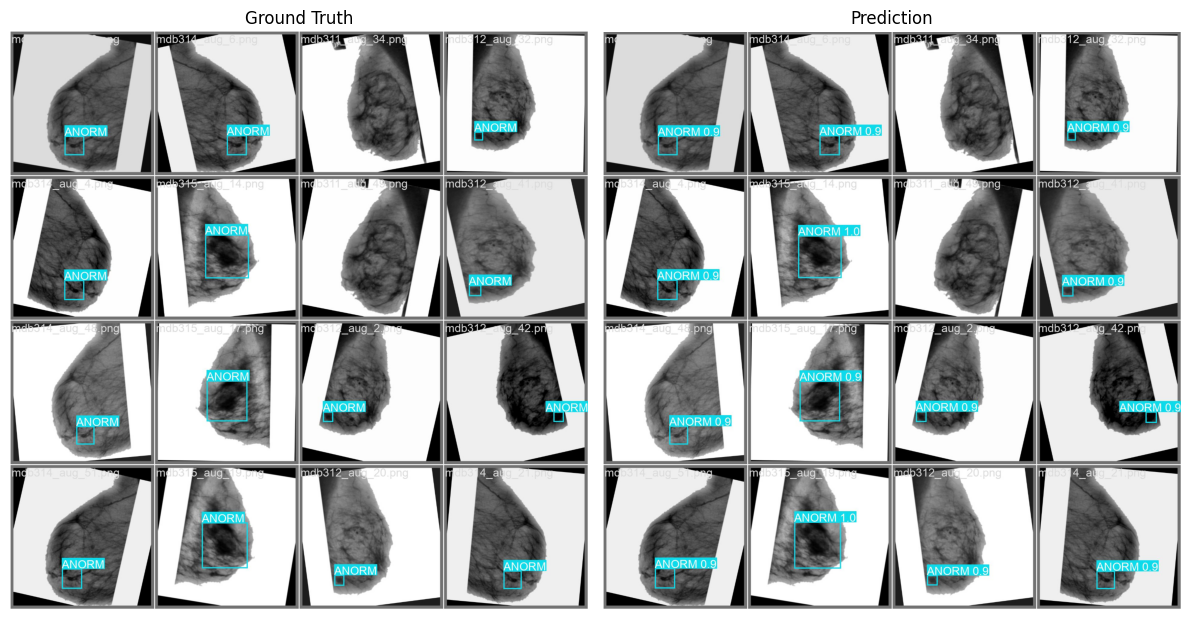

In [ ]:
# Load the images
truth = cv2.imread(ground_truth)  # Replace with your ground truth image path
pred = cv2.imread(prediction)     # Replace with your prediction image path

# Convert BGR (OpenCV) to RGB (Matplotlib)
truth = cv2.cvtColor(truth, cv2.COLOR_BGR2RGB)
pred = cv2.cvtColor(pred, cv2.COLOR_BGR2RGB)

# Create a figure with 1 row and 2 columns
plt.figure(figsize=(12, 8))

# Display the ground truth image
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.imshow(truth)
plt.title('Ground Truth')
plt.axis('off')  # Hide axes

# Display the prediction image
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.imshow(pred)
plt.title('Prediction')
plt.axis('off')  # Hide axes

# Show the plot
plt.tight_layout()  # Adjust spacing between subplots
plt.show()